In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from plot_func import my_anima_1d_h_u
from IPython.display import HTML

In [3]:
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import math


In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Shallow Water Equation - 1D Linear

Continuity Equation
$$\frac{\partial h}{\partial t}+ H\frac{\partial u}{\partial x}=0 $$
Momentum Equation
$$\frac{\partial u}{\partial t} = - g\frac{\partial h}{\partial x} $$


In [5]:
# define ANN structure
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_Tanh_stack = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 2),
        )

    def forward(self, x):
        logits = self.linear_Tanh_stack(x)
        return logits
# define PINN structure
class PINN():
    def __init__(self,t_axis, x_axis, IC_func, g, H):
        # accounting for scale change by normalization
        self.t_min_max = [t_axis.min(),t_axis.max()]
        self.x_min_max = [x_axis.min(),x_axis.max()]
        self.t_grad_scale = torch.tensor(1/(t_axis.max()-t_axis.min())).to(device) 
        self.x_grad_scale = torch.tensor(1/(x_axis.max()-x_axis.min())).to(device) 
        
        #parameters
        self.g = torch.tensor(g).to(device)
        self.H = torch.tensor(H).to(device)
        
        # initialization grids from regular x and t
        # Collocation points 
        t_axis_nor,x_axis_nor = self.coordination_normalization(t_axis,x_axis)
        self.tx_col = self.cartesian_coord_to_ij(t_axis_nor[:], x_axis_nor) 
        # BC points
        self.BC_tx_l  = self.cartesian_coord_to_ij(t_axis_nor, x_axis_nor[ 0])
        self.BC_tx_r  = self.cartesian_coord_to_ij(t_axis_nor, x_axis_nor[-1])  
        # IC points 
        self.IC_tx  = self.cartesian_coord_to_ij(t_axis_nor[0], x_axis_nor)
        IC_expected = IC_func(x_axis) # x before normalization
        self.IC_expected = torch.tensor(IC_expected).to(device) 
        # Collocation points with require gradient = True
        self.tx_col.requires_grad  = True
        self.BC_tx_l.requires_grad = True
        self.BC_tx_r.requires_grad = True
     # initial ANN
        self.NN_model = NeuralNetwork().to(device)
#         self.optimizer = torch.optim.SGD(self.NN_model.parameters(),lr=0.01)
        self.optimizer = torch.optim.Adam(self.NN_model.parameters(), lr=0.001, betas=(0.9, 0.999))
        self.optimizer_warmup = torch.optim.Adam(self.NN_model.parameters(), lr=0.001, betas=(0.9, 0.999))
    def cartesian_coord_to_ij(self, t_axis, x_axis):
        t_col,x_col = np.meshgrid(t_axis, x_axis, indexing='ij') 
        # time & space mesh in rows
        tx_col = np.concatenate((t_col.reshape(-1,1), x_col.reshape(-1,1)), 
                                axis=1,dtype='float32')
        return torch.tensor(tx_col).to(device) 

    def coordination_normalization(self,t_axis,x_axis):
        t_axis_nor = (t_axis-self.t_min_max[0])*self.t_grad_scale.item()-0.5
        x_axis_nor = (x_axis-self.x_min_max[0])*self.x_grad_scale.item()-0.5
        return t_axis_nor,x_axis_nor 

####### define loss function
    def output_gradient(self,output,tx_col):
        output_tx = torch.autograd.grad(output,tx_col,grad_outputs=torch.ones_like(output), 
                                        create_graph=True)[0]
        return output_tx
    # physics constrainn
    def loss_PDE(self,tx_col):
        output = self.NN_model(tx_col)
        h = output[:,0] 
        u = output[:,1] 
        h_tx = self.output_gradient(h,tx_col)
        u_tx = self.output_gradient(u,tx_col)
        h_t = h_tx[:,0]
        h_x = h_tx[:,1]
        u_t = u_tx[:,0]
        u_x = u_tx[:,1]
        # PDE1 : Continuity equation
        # \frac{\partial h}{\partial t}+ u\frac{\partial h}{\partial x} + h\frac{\partial u}{\partial x}=0
        LHS1 = h_t * ( self.t_grad_scale/self.x_grad_scale)  #+ u * h_x 
        RHS1 = - self.H * u_x 
        loss_f1 = torch.nn.MSELoss()(LHS1, RHS1)
        # PDE2: x Momentum Equation
        # \frac{\partial u}{\partial t}+ u\frac{\partial u}{\partial x} = - g\frac{\partial h}{\partial x}$$
        LHS2 = u_t * ( self.t_grad_scale/self.x_grad_scale)  #+ u * u_x 
        RHS2 = - self.g * h_x 
        loss_f2 = torch.nn.MSELoss()(LHS2, RHS2)
        return loss_f1, loss_f2

    def loss_BC(self):
        # setup periodic B.C. via loss function
        # (mixed type with derivative periodic need to test)
        # 1st type B.C. via loss function
        # periodic values, for t=?, output(x=-1) = output(x=1)
        output_bc_l = self.NN_model(self.BC_tx_l)
        output_bc_r = self.NN_model(self.BC_tx_r)
        loss        = torch.nn.MSELoss()(output_bc_l, output_bc_r)
#         # 2nd B.C. derivative via loss function # need more research
#         # periodic derivative, for t=?, output_xt(x=-1) = output_xt(x=1)
#         output_bc_l_xt = self.output_gradient(self.BC_tx_l)
#         output_bc_r_xt = self.output_gradient(self.BC_tx_r)
#         loss       += torch.nn.MSELoss()(output_bc_l_xt, output_bc_r_xt)
        return loss

    def loss_IC(self):
        # periodic values, for x=?, output(t=0) = IC_expected
        output = self.NN_model(self.IC_tx)
        loss = torch.nn.MSELoss()(output, self.IC_expected)
        return loss
####batch    
    def col_poi_batch_index_sta_end(self,col_poi,col_poi_batch_size):
        n_batch = math.ceil(col_poi.shape[0]/col_poi_batch_size)
        col_poi_batchs = []
        sta=0
        for i in range(n_batch-1):
            end = sta + col_poi_batch_size
            col_poi_batchs.append(col_poi[sta:end,:])
            sta = end
        col_poi_batchs.append(col_poi[sta:col_poi.shape[0],:])
        return col_poi_batchs
####training functions
    def train_IC_warmup(self,optimizer=None):
        if optimizer is None:
            optimizer = self.optimizer_warmup
#         loss = self.loss_BC()
        loss = self.loss_IC()  
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
    def train(self,col_poi_batch_size=None,optimizer=None):
        if optimizer is None:
            optimizer = self.optimizer
        if col_poi_batch_size is None:
            col_poi_batch_size=self.tx_col.shape[0]
        # create training dataset (index) for collocation points
        # 1st method: loop thourgh all points in batch and in order
        col_poi_batchs = self.col_poi_batch_index_sta_end(self.tx_col,col_poi_batch_size)
#         # 2nd method: loop thourgh all points randomly in batch
        
        for tx_col_batch in col_poi_batchs:
#             Compute loss: function loss + BC/IC loss
            lossf1,lossf2 = self.loss_PDE(tx_col_batch) 
            loss2 = self.loss_BC()
            loss3 = self.loss_IC()  
            loss = lossf1 + lossf2 + loss2 + 5*loss3 # large on IC
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()    
# quick output 
    def predict(self,tx_col=None):
        if tx_col is None:
#             tx_col = torch.cat((self.IC_tx,self.tx_col),dim=0)
            tx_col = self.tx_col
        with torch.no_grad():
            output = self.NN_model(tx_col)
        return output
    def current_loss(self):
        # Compute loss: function loss + BC/IC loss
        lossf1,lossf2 = self.loss_PDE(self.tx_col) 
        loss2 = self.loss_BC()
        loss3 = self.loss_IC()  
        return [lossf1.item(),lossf2.item(),loss2.item(),loss3.item()]

In [6]:
# %%time
t_end = 2
# set regular grid
t_axis = np.arange(0,t_end,0.005,dtype='float32')    # time
x_axis = np.arange(-1,1+1e-3,0.01,dtype='float32')   # space
 
# def IC_func(x): # set IC 
#     return np.concatenate([np.sin(x[:,None]*np.pi), np.zeros_like(x[:,None])],axis=1)
#     return np.concatenate([np.sign(x[:,None]), np.zeros_like(x[:,None])],axis=1)
def IC_func(x):
    IC_h = np.ones_like(x)
    IC_h = np.where(np.logical_and(x>=-0.5, x<0.5),IC_h,0)
    return np.concatenate([IC_h[:,None], np.zeros_like(x[:,None])],axis=1)

adv_1d_solver = PINN(t_axis=t_axis, x_axis=x_axis,IC_func=IC_func, g=1, H=1)
loss = []

# Run/Train model/PDE solver

In [7]:
def print_loss(i,loss_tmp):
    if i is not None:
        print(f'Epoch {i:6d} ', end='')
    print(f'| fn loss1: {loss_tmp[0]:8.2e} '
         +f'| fn loss2: {loss_tmp[1]:8.2e} '
         +f'| BC loss: {loss_tmp[2]:8.2e} '
         +f'| IC loss: {loss_tmp[3]:8.2e} ')

In [8]:
%%time
N_save_num = 20 # how many times of output
N_epoch_batch = 100
Warmup_ICBC = True


N_epoch = N_save_num*N_epoch_batch
IC_epochs = np.zeros((N_save_num,x_axis.size,2),dtype='float32')

if Warmup_ICBC is True:
    for i in range(400): # use 10 epoch to warmup IC
        adv_1d_solver.train_IC_warmup()
    loss_tmp = adv_1d_solver.current_loss()
    loss.append(loss_tmp)
    print('Warmup_ICBC:',end=' ')
    print_loss(None,loss_tmp)
for i in range(N_epoch):
    # train and get loss: iter_nums per epoch
    adv_1d_solver.train(col_poi_batch_size=int(t_axis.size*x_axis.size/20))
    if i%N_epoch_batch == 0:    
        loss_tmp = adv_1d_solver.current_loss()
        loss.append(loss_tmp)
        print_loss(i,loss_tmp)
        # predict and save output of NN_model
        output = adv_1d_solver.predict().reshape((t_axis.size,x_axis.size,2))
        IC_epochs[int(i/N_epoch_batch),:,:] = output.to('cpu')[0,:,:]

Warmup_ICBC: | fn loss1: 4.25e-02 | fn loss2: 1.32e+01 | BC loss: 1.28e-02 | IC loss: 1.30e-02 
Epoch      0 | fn loss1: 1.23e-02 | fn loss2: 1.04e+00 | BC loss: 1.37e-01 | IC loss: 1.20e-01 
Epoch    100 | fn loss1: 1.44e-02 | fn loss2: 1.56e-02 | BC loss: 4.88e-02 | IC loss: 2.30e-02 
Epoch    200 | fn loss1: 4.34e-02 | fn loss2: 1.61e-02 | BC loss: 3.97e-02 | IC loss: 1.45e-02 
Epoch    300 | fn loss1: 3.04e-02 | fn loss2: 1.60e-02 | BC loss: 4.51e-02 | IC loss: 1.19e-02 
Epoch    400 | fn loss1: 2.30e-02 | fn loss2: 2.87e-02 | BC loss: 3.78e-02 | IC loss: 8.76e-03 
Epoch    500 | fn loss1: 3.32e-02 | fn loss2: 4.09e-02 | BC loss: 2.50e-02 | IC loss: 8.38e-03 
Epoch    600 | fn loss1: 1.58e-02 | fn loss2: 2.18e-02 | BC loss: 2.27e-02 | IC loss: 5.48e-03 
Epoch    700 | fn loss1: 1.15e-02 | fn loss2: 1.33e-02 | BC loss: 2.15e-02 | IC loss: 4.81e-03 
Epoch    800 | fn loss1: 1.76e-02 | fn loss2: 1.22e-02 | BC loss: 1.36e-02 | IC loss: 4.44e-03 
Epoch    900 | fn loss1: 7.46e-03 | fn l

# Show Training process for IC

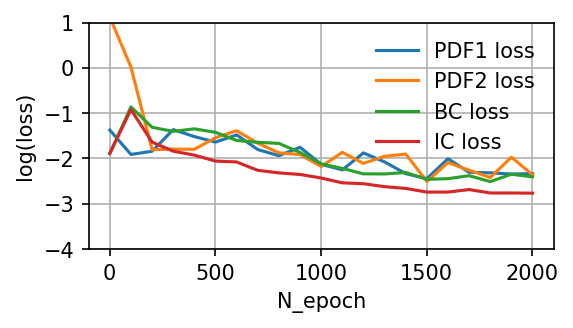

In [32]:
#plot loss
loss_list = np.array(loss)
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(4,2),dpi=150) 
N_epoch = np.arange(loss_list.shape[0])*N_epoch_batch+1
axs.plot(N_epoch,np.log(loss_list[:,0])/np.log(10),label='PDF1 loss')
axs.plot(N_epoch,np.log(loss_list[:,1])/np.log(10),label='PDF2 loss')
axs.plot(N_epoch,np.log(loss_list[:,2])/np.log(10),label='BC loss')
axs.plot(N_epoch,np.log(loss_list[:,3])/np.log(10),label='IC loss')
axs.legend(frameon=False)
plt.ylabel('log(loss)')
plt.xlabel('N_epoch')
plt.ylim([-4,1])
plt.grid()
fig.show()

/tmp/ipykernel_58996/1469745680.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


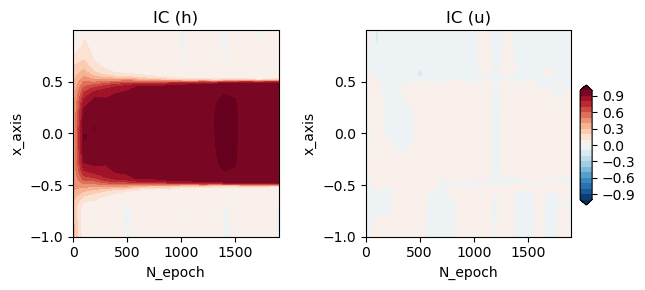

In [10]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(6,3),dpi=100) 
axs = axs.flatten()
levels = np.arange(-1,1.05,0.1)
ax = axs[0]
cb = ax.contourf(np.arange(N_save_num)*N_epoch_batch,x_axis,IC_epochs[:,:,0].T,
                 levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('N_epoch')
ax.set_ylabel('x_axis')
ax.set_title('IC (h)')
ax = axs[1]
cb = ax.contourf(np.arange(N_save_num)*N_epoch_batch,x_axis,IC_epochs[:,:,1].T,
                 levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('N_epoch')
ax.set_ylabel('x_axis')
ax.set_title('IC (u)')

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.4])
# Draw the colorbar
cbar = fig.colorbar(cb, cax=cbar_ax,orientation='vertical')
fig.tight_layout()

# Final result

/tmp/ipykernel_58996/3653467019.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


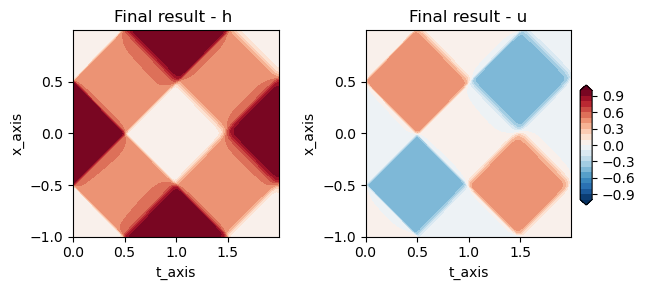

In [11]:
output = adv_1d_solver.predict().reshape((t_axis.size,x_axis.size,2)).to('cpu')
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(6,3),dpi=100) 
axs = axs.flatten()
levels = np.arange(-1,1.05,0.1)
ax = axs[0]
ax.contourf(t_axis,x_axis,output[:,:,0].T,
                 levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('t_axis')
ax.set_ylabel('x_axis')
ax.set_title('Final result - h ')
ax = axs[1]
ax.contourf(t_axis,x_axis,output[:,:,1].T,
                 levels=levels,extend='both',cmap=plt.cm.RdBu_r)

ax.set_xlabel('t_axis')
ax.set_ylabel('x_axis')
ax.set_title('Final result - u')

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.99, 0.3, 0.02, 0.4])
# Draw the colorbar
cbar = fig.colorbar(cb, cax=cbar_ax,orientation='vertical')
fig.tight_layout()

## Energy Conservation

E_p = g|h|h/2

E_k = 0.5Hu^2

In [12]:
dx = x_axis[1]-x_axis[0]
E_p = adv_1d_solver.g.item()*(output[:,:,0]*abs(output[:,:,0])).sum(axis=1)/2*dx
E_k = 0.5**adv_1d_solver.H.item()*(output[:,:,1]**2).sum(axis=1)*dx

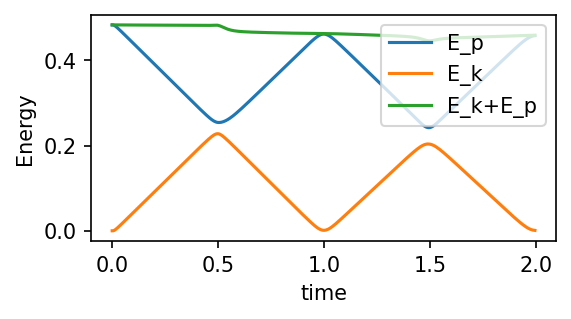

In [18]:
fig, axs = plt.subplots(nrows=1,ncols=1, figsize=(4,2),dpi=150) 
plt.plot(t_axis,E_p,label='E_p')
plt.plot(t_axis,E_k,label='E_k')
plt.plot(t_axis,E_k+E_p,label='E_k+E_p')
plt.xlabel('time')
plt.ylabel('Energy')
plt.legend(loc=1)
fig.show()

## Output to different grid (mesh free feature)

In [14]:
# regular grid
t_hr = np.arange(0,t_end,0.003,dtype='float32')    # time
x_hr = np.arange(-1,1+1e-3,3e-3,dtype='float32')   # space
t_hr_nor,x_hr_nor = adv_1d_solver.coordination_normalization(t_hr,x_hr)
hr_tx = adv_1d_solver.cartesian_coord_to_ij(t_hr_nor,x_hr_nor)
output_hr = adv_1d_solver.predict(hr_tx).reshape((t_hr.size,x_hr.size,2)).to('cpu').numpy()

In [15]:
fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(6,4),dpi=100,facecolor=(1.0, 1.0, 1.0)) 
anim = my_anima_1d_h_u(fig, axs,x_hr,t_hr,output_hr[:,:,0],output_hr[:,:,1])
axs[0].set_ylabel('h')
axs[1].set_ylabel('u')
HTML(anim.to_html5_video())

## time slice diganose

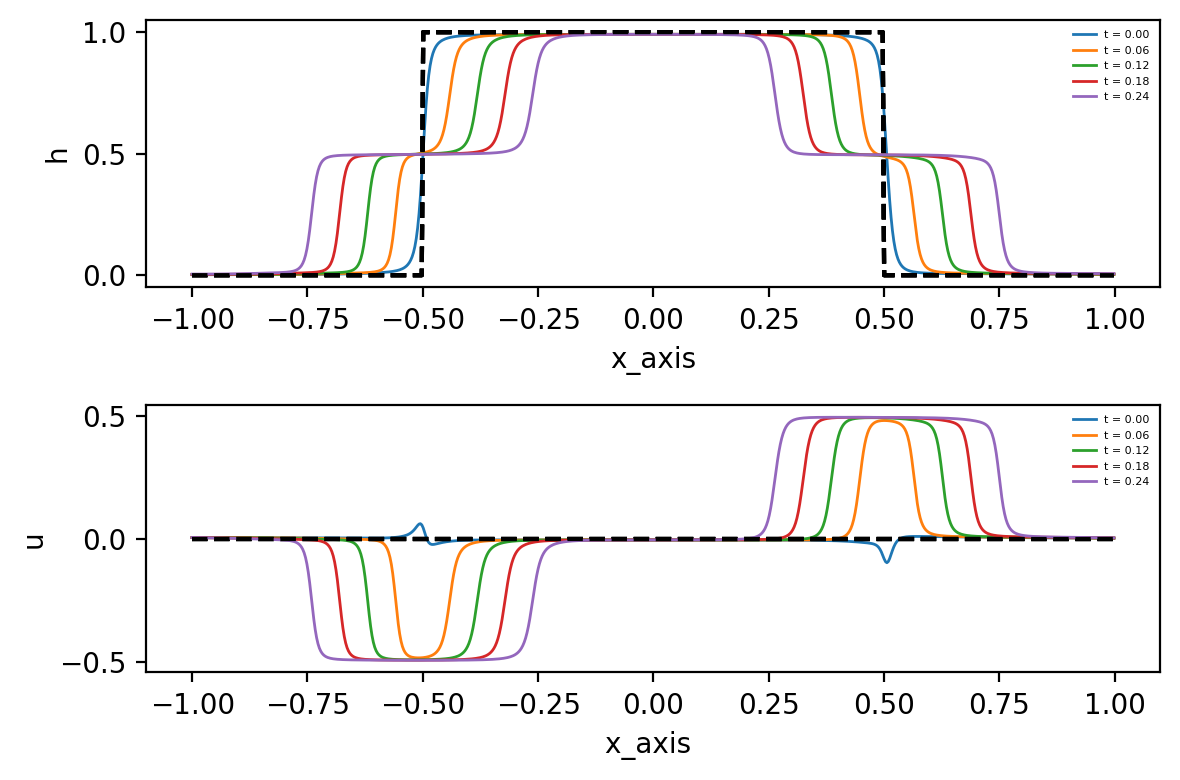

In [16]:
fig, axs = plt.subplots(nrows=2,ncols=1, figsize=(6,4),dpi=200) 
ax = axs[0]
for t_i in np.arange(0,100,20):
    p=ax.plot(x_hr,output_hr[t_i,:,0],linewidth=1,label = f"t = {t_hr[t_i]:4.2f}")
#     x_tmp = x_trace_back(x_axis,x_hr,t_hr[t_i])
    ax.plot(x_hr,IC_func(x_hr)[:,0],'--',c='black')
ax.legend(frameon=False, fontsize=4)
ax.set_xlabel('x_axis')
ax.set_ylabel('h')
ax = axs[1]
for t_i in np.arange(0,100,20):
    p=ax.plot(x_hr,output_hr[t_i,:,1],linewidth=1,label = f"t = {t_hr[t_i]:4.2f}")
#     x_tmp = x_trace_back(x_axis,x_hr,t_hr[t_i])
    ax.plot(x_hr,IC_func(x_hr)[:,1],'--',c='black')
ax.legend(frameon=False, fontsize=4)
ax.set_xlabel('x_axis ')
ax.set_ylabel('u')
fig.tight_layout()

# Exit